# **`VODAFONE CORPORATION CUSTOMER CHURN PREDICTION`**

## **`Business Understanding`**

## `Problem Statement`

Telecommunication companies, such as Vodafone Corporation, face a significant challenge with customer churn, where customers cease using their services. To address this issue effectively, it's crucial to anticipate which customers are at risk of churning and implement proactive retention strategies. Leveraging machine learning models can provide a solution by predicting potential churners based on various factors, including usage patterns, payment history, and demographic data.

## `Project Goal`

This project aims to:
- Determine the likelihood of customer churn based on certain characteristics such as gender
- Identify key indicators of churn
- Propose effective retention strategies to mitigate customer attrition.
- Train Classification Machine Learning algorithm to help predict the likelihood of a customer to churn

## `Hypothesis`

| Hypothesis Description                                                    |                                                                      |
|---------------------------------------------------------------------------|----------------------------------------------------------------------|
| Null Hypothesis (H0)                                                      | Customers with Month-to-Month contracts are equally likely to churn as those with one-year and two-year contracts.                  |
| Alternative Hypothesis (H1)                                               | Customers with Month-to-Month contracts are more likely to churn compared to those with one-year and two-year contracts.           |


## `Analytical Questions`

1. **From which contract do most churners originate?**
2. **Which gender exhibits the highest churn rate?**
3. **How does the number of lines a customer has influence churn?**
4. **Which internet service experiences the highest churn rate?**
5. **How does churn compare between customers with and without tech support?**
6. **Who churns more: customers with phone service or those without?**
7. **Who churns more: customers with paperless billing or those without?**
8. **During which tenures does churn occur most frequently?**


# **`Data Understanding`**


## Data Loading

### Notes:
**Our dataset is stored in three separate areas**:
- Our first dataset is the first 3000 records of the dataset and will be found in a database we will have to access remotely
- The second part of the data is hosted on a GitHub Repository. The data is a csv file and we will have to download it
- The final 2000 records of the data set needed for this project will be found in OneDrive. The data is a csv file and we will have to download it. **. This Dataset will be used for testing the accuracy of our models.**

In [1]:
# Import libraries
from dotenv import dotenv_values
import warnings
warnings.filterwarnings('ignore')
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

In [3]:
# Create a connection with the remote databse
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"
connection = pyodbc.connect(connection_string)

In [4]:
# load first dataset
# Load database churn data from the database
churn_data1="SELECT * FROM dbo.LP2_Telco_churn_first_3000"
churn_data1=pd.read_sql(churn_data1,connection)

# Save database churn data to a csv file
'''file_name='churn_data1.csv'
churn_data1.to_csv(file_name,index=False)'''

"file_name='churn_data1.csv'\nchurn_data1.to_csv(file_name,index=False)"

In [5]:
# load second dataset from a GitHub Repository
# The data is saved in a csv file
churn_data2=pd.read_csv('Data/LP2_Telco-churn-second-2000.csv')

In [6]:
# load the third dataset saved in OneDrive.
#The data is excel format
# This dataset will be usData\Telco-churn-last-2000.xlsx
test_data=pd.read_excel('Data/Telco-churn-last-2000.xlsx')

In [7]:
pd.set_option('display.max_columns',21) #Display maximum number of columns
churn_data1.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [8]:
churn_data2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,No,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,No,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [9]:
test_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


In [10]:
# Concatenate dataset 1 and 2 to form the train dataset
train_data=pd.concat([churn_data1, churn_data2], ignore_index=True)
train_data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,0,False,False,45,False,None,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.800000,1990.5,No
5039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.200000,7362.9,No
5040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.600000,346.45,No
5041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.400000,306.6,Yes


## Exploratory Data Analysis

In [11]:
# Get shape of the datasets
train_data.shape,test_data.shape

((5043, 21), (2000, 20))

In [12]:
# check train_data columns
train_data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [13]:
test_data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [14]:
# Function to change headers to lowercase
def data_columns_lower(data):
    data.columns = data.columns.str.lower()
    return data

In [15]:
# Change train columns to lowercase
data_columns_lower(train_data)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,0,False,False,45,False,None,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.800000,1990.5,No
5039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.200000,7362.9,No
5040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.600000,346.45,No
5041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.400000,306.6,Yes


In [16]:
# Change test data columns to lowercase
data_columns_lower(test_data)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,7912-SYRQT,Female,0,No,No,7,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),75.10,552.95
1996,3557-HTYWR,Female,0,No,No,47,Yes,Yes,DSL,Yes,Yes,No,Yes,No,Yes,Two year,No,Mailed check,74.05,3496.3
1997,4816-JBHOV,Male,1,No,No,2,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,44.70,93.7
1998,8920-NAVAY,Male,1,No,No,62,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),110.75,7053.35


In [17]:
# Describe numeric data
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
seniorcitizen,5043.0,0.162403,0.368857,0.0,0.000,0.000000,0.000000,1.000000
tenure,5043.0,32.576641,24.529807,0.0,9.000,29.000000,56.000000,72.000000
monthlycharges,5043.0,65.090214,30.068133,18.4,35.775,70.550003,90.050003,118.650002


In [18]:
# Describe categorical data
train_data.describe(include='O').T 

,count,unique,top,freq
customerid,5043,5043,7590-VHVEG,1
gender,5043,2,Male,2559
partner,5043,4,False,1538
dependents,5043,4,False,2070
phoneservice,5043,4,True,2731
multiplelines,4774,5,False,1437
internetservice,5043,3,Fiber optic,2248
onlinesecurity,4392,5,False,1478
onlinebackup,4392,5,False,1320
deviceprotection,4392,5,False,1296


In [19]:
# Check for nulls
# percentage of nulls
percent_nulls = pd.DataFrame((train_data.isnull().sum().sort_values(ascending=False) * 100) / len(train_data), columns=['Percentage of Null Values'])

# absolute nulls
nulls_abs = pd.DataFrame(train_data.isnull().sum().sort_values(ascending=False), columns=['Count of Null values'])

# combine in a df
nulls = pd.concat([percent_nulls, nulls_abs], axis=1)
nulls.reset_index(inplace=True)
nulls.rename(columns={'index': 'Column'}, inplace=True)

nulls

,Column,Percentage of Null Values,Count of Null values
0,onlinebackup,12.908983,651
1,onlinesecurity,12.908983,651
2,streamingmovies,12.908983,651
3,streamingtv,12.908983,651
4,techsupport,12.908983,651
5,deviceprotection,12.908983,651
6,multiplelines,5.334127,269
7,totalcharges,0.099147,5
8,churn,0.019829,1
9,internetservice,0.000000,0


In [20]:
# Check for duplicates
train_data.duplicated().sum()

0

In [21]:
# Create a function to get the columns where False, True, Yes and No are present
def check_column_values(df):
    columns = []
    for column in df.columns:
        unique_values = df[column].astype(str).unique()  # Convert values to strings
        if all(value.lower() in [x.lower() for x in unique_values] for value in ['True', 'False', 'Yes', 'No']):
            columns.append(column)
    return columns
def filtered_target_columns(check_column_values):
    target_columns = check_column_values(train_data)
    return target_columns
target_columns = filtered_target_columns(check_column_values)
target_columns

['partner',
 'dependents',
 'phoneservice',
 'multiplelines',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'paperlessbilling',
 'churn']

In [22]:
# Create a function that maps the column values and replaces True with Yes and False with No
def unify_column_values(df,columns):
    for column in columns:
        df[column]=df[column].replace({True:'Yes',False:'No'})
def unified_columns():
    return target_columns

unify_column_values(train_data,unified_columns())

### Notes:
We will create a fuction that will print all the unified columns and the number of values for each category

In [23]:
# Create a function to print the unified columns and the number of values for each category
def get_clean_target_columns(df, target_columns):
    def clean_target_columns(column):
        return column
    result = {}
    for column in df.columns:
        if column in target_columns:
            column_values = df[column].value_counts()
            column_values.columns = [column, 'count']
            result[clean_target_columns(column)] = column_values
    for column, column_df in result.items():
        print(f"\nColumn: {column}")
        print(column_df)
get_clean_target_columns(train_data, target_columns)


Column: partner
partner
No     2585
Yes    2458
Name: count, dtype: int64

Column: dependents
dependents
No     3482
Yes    1561
Name: count, dtype: int64

Column: phoneservice
phoneservice
Yes    4554
No      489
Name: count, dtype: int64

Column: multiplelines
multiplelines
No                  2424
Yes                 2130
No phone service     220
Name: count, dtype: int64

Column: onlinesecurity
onlinesecurity
No                     2507
Yes                    1456
No internet service     429
Name: count, dtype: int64

Column: onlinebackup
onlinebackup
No                     2231
Yes                    1732
No internet service     429
Name: count, dtype: int64

Column: deviceprotection
deviceprotection
No                     2219
Yes                    1744
No internet service     429
Name: count, dtype: int64

Column: techsupport
techsupport
No                     2472
Yes                    1491
No internet service     429
Name: count, dtype: int64

Column: streamingtv
streamingt

### Notes:
- Also, during our data exploration, we noticed that the customer ID column is not useful in our analysis. Therefore, we are going to drop the column
- We will also convert the total charges to numeric 

In [24]:
# Drop the customer ID column
train_data.drop('customerid', axis=1, inplace=True)

In [25]:
# Convert total charges column to numeric
train_data['totalcharges'] = pd.to_numeric(train_data['totalcharges'], errors='coerce')

In [26]:
# vonvert senior citizen to object
train_data['seniorcitizen']=train_data['seniorcitizen'].astype('object')

## Univariate Analysis

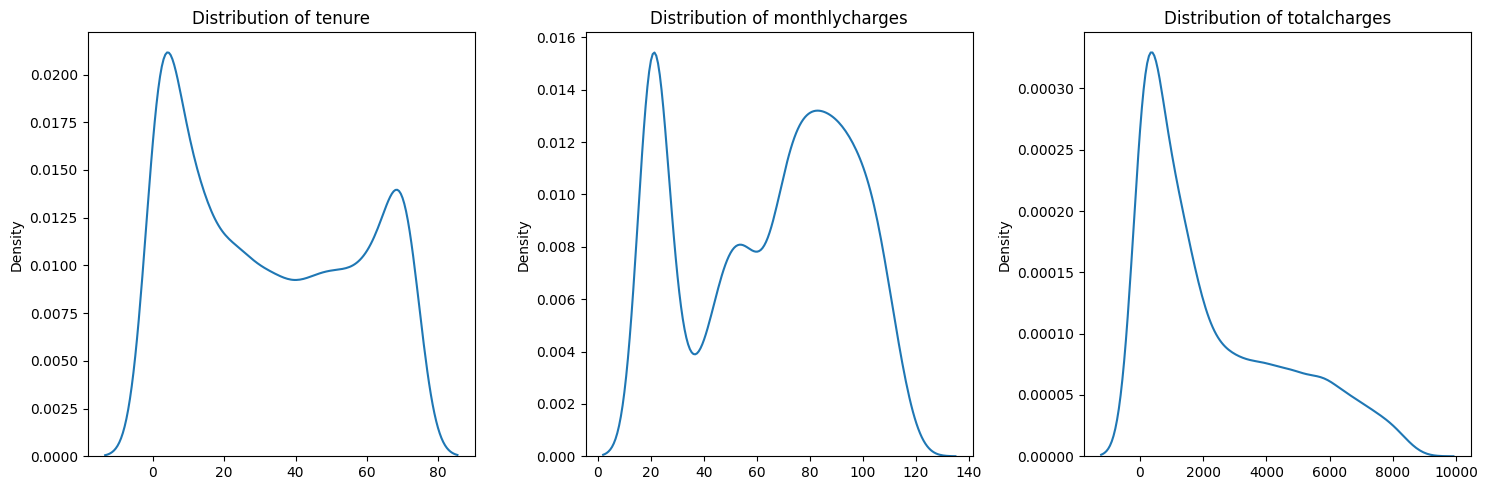

In [27]:
def distribution_plots(df):
    numeric_columns = df.select_dtypes(include='number').columns
    num_plots = len(numeric_columns)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, column in enumerate(numeric_columns):
        sns.kdeplot(data=df, x=column, ax=axes[i])
        axes[i].set_title(f"Distribution of {column}")
        axes[i].set_xlabel("")
    plt.tight_layout()
    plt.show()

distribution_plots(train_data)

**Notes**
- All the data is not distributed normally and is lacking symmetry. This is an indication we will need to standardize the data so that it follows Gaussian distribution

In [28]:
def categorical_distribution(df):
    for col in df.select_dtypes(include='object').columns:
        ax=sns.countplot(data=df, x=col)
        plt.title(f"Distribution of {col}")
        plt.xlabel("")
        plt.ylabel("Count")
        for i in ax.containers:
            plt.bar_label(i,)
        plt.show()

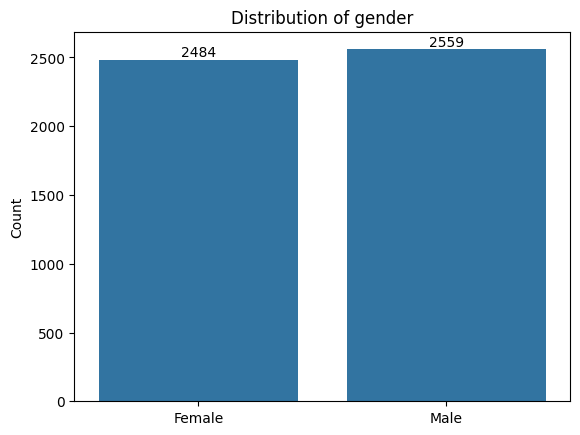

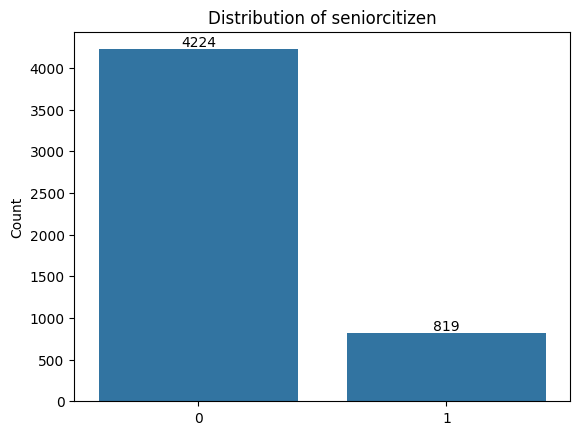

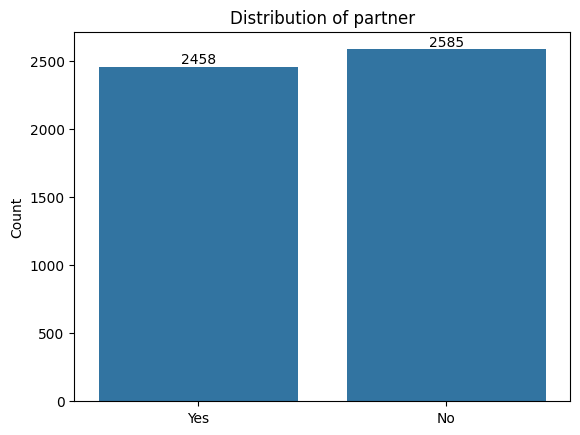

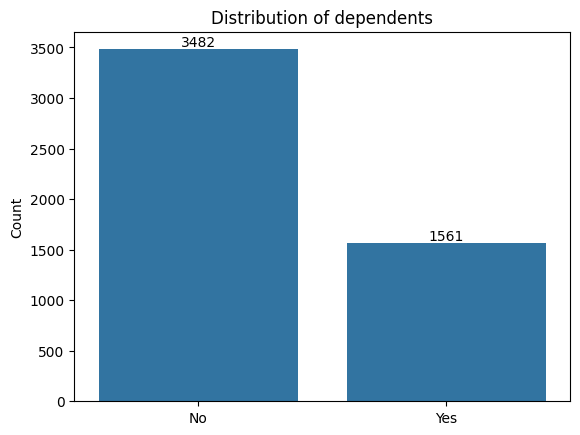

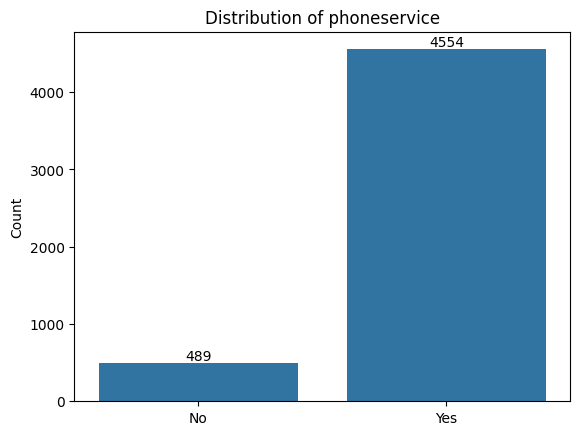

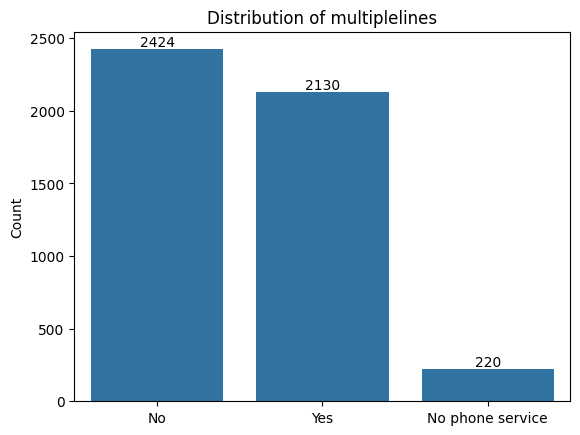

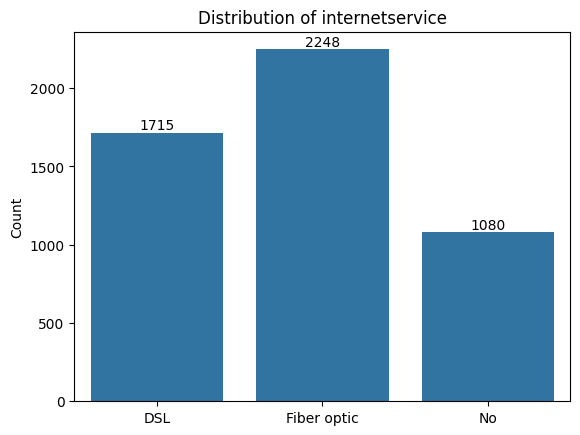

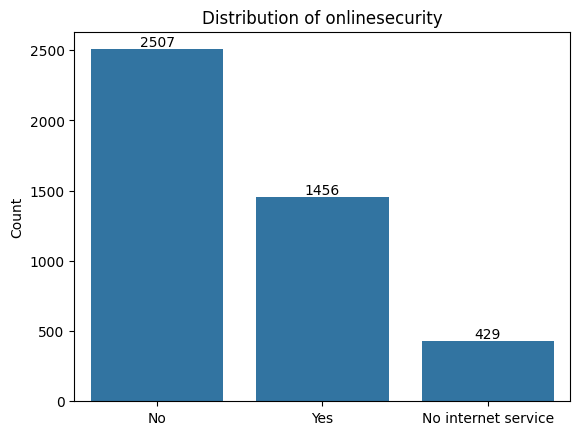

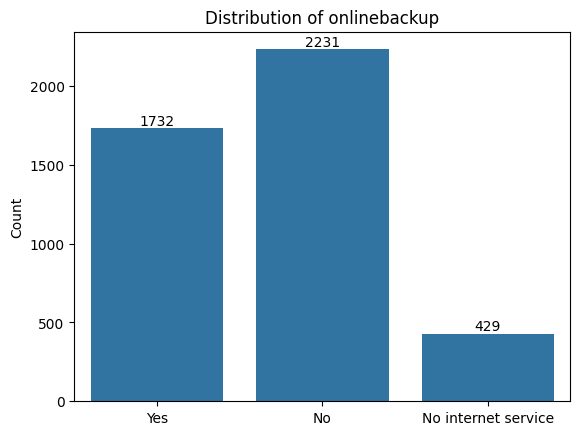

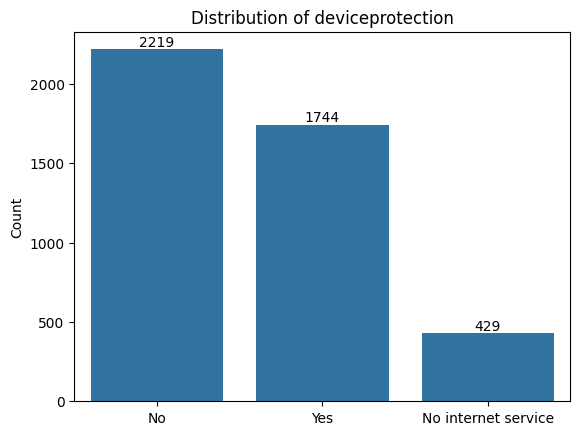

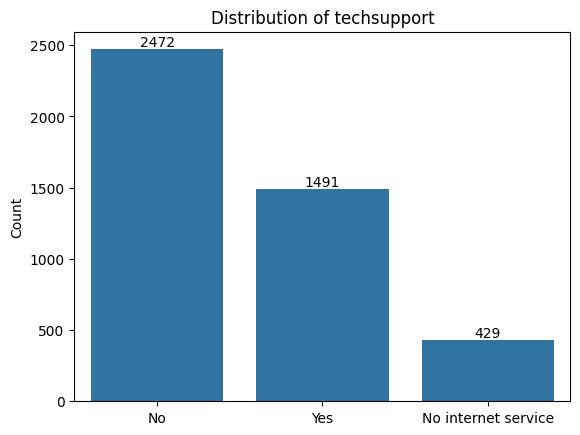

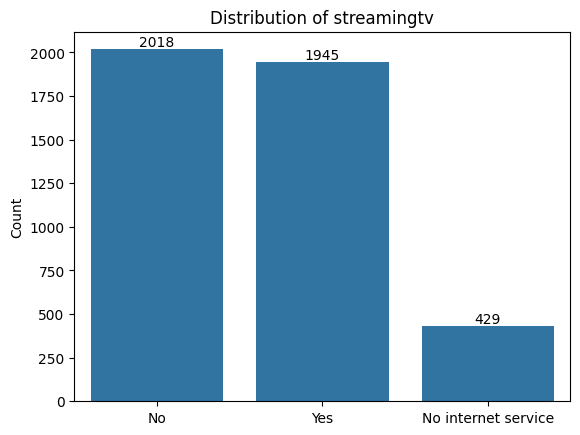

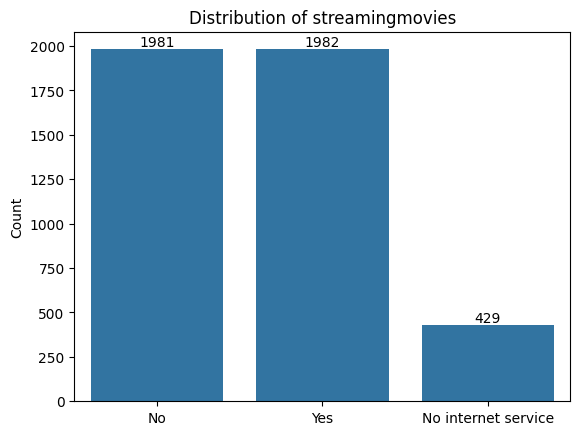

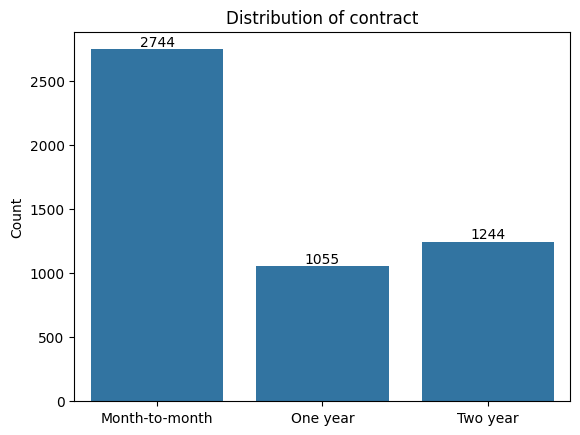

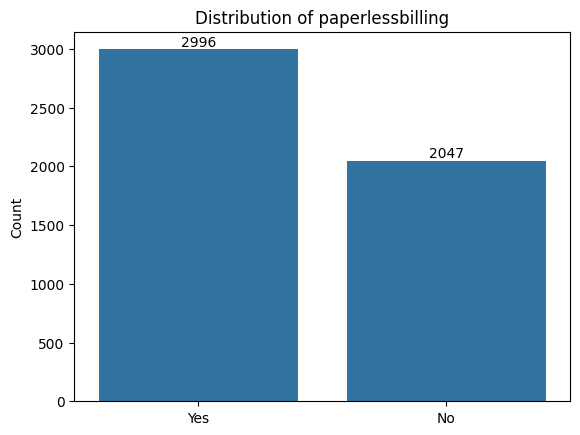

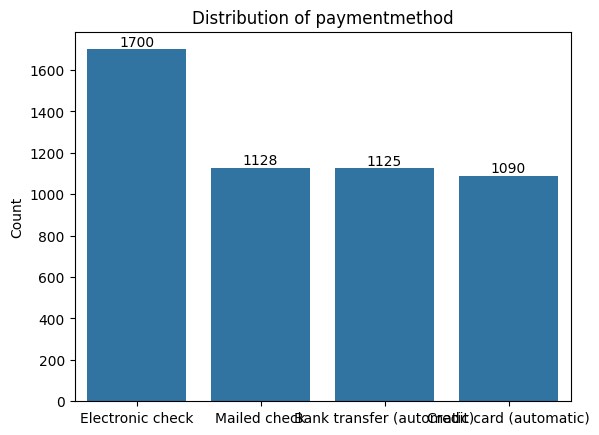

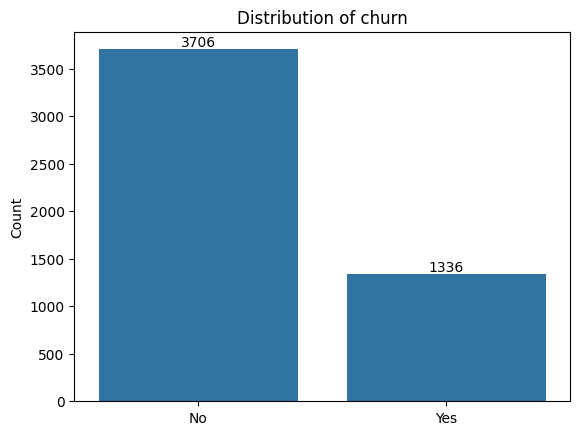

In [29]:
categorical_distribution(train_data)

## Bivariate Analysis

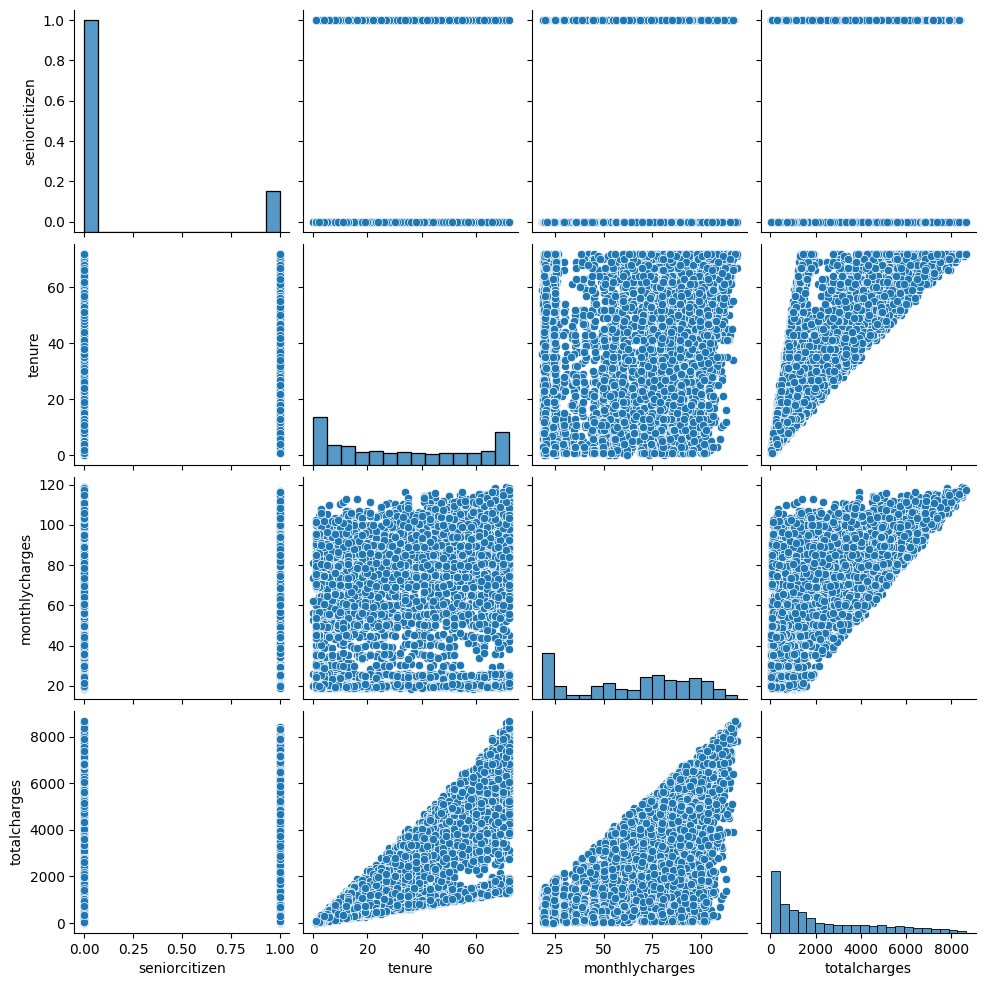

In [30]:
# paiplots
sns.pairplot(train_data)
plt.show()

In [31]:
# fuction to plot violin plots for every column vs churn column
def violin_plots(df):
    for column in df.columns:
        if column !='churn':
         sns.violinplot(x='churn', y=column, data=df)
         plt.title(f'Violin plot of {column} vs churn')
         plt.xlabel('churn')
         plt.ylabel(column)
         plt.show()

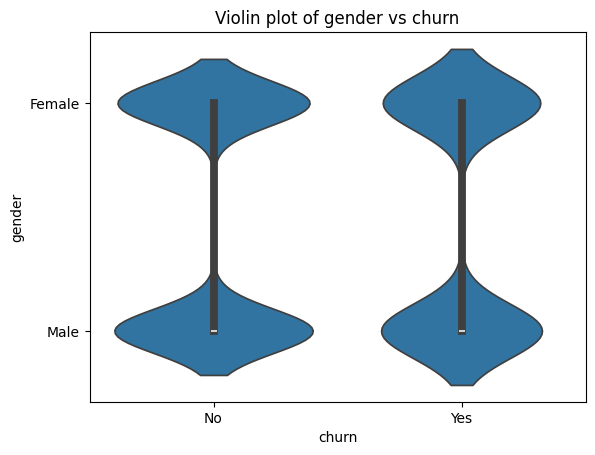

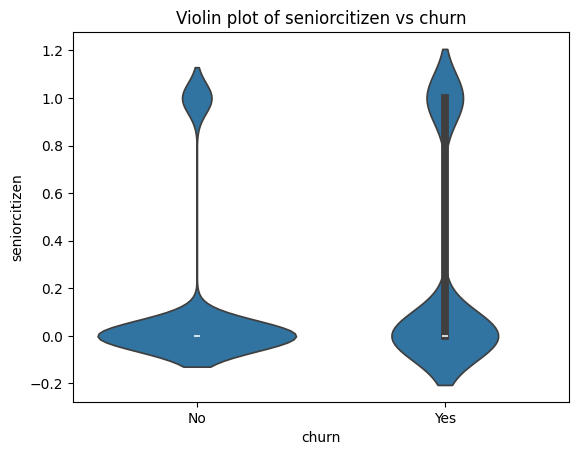

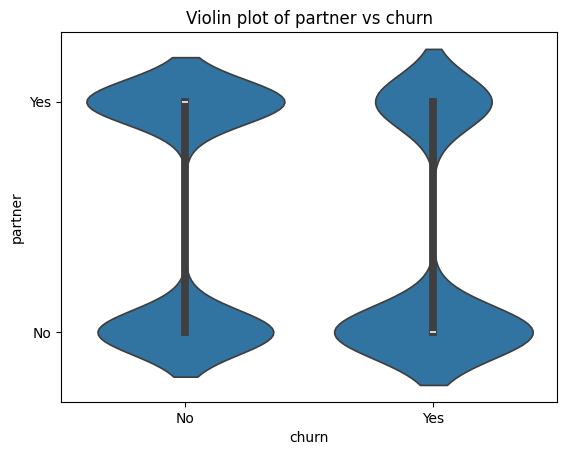

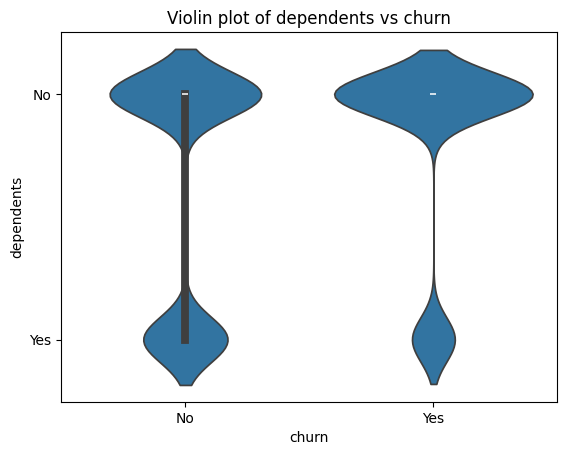

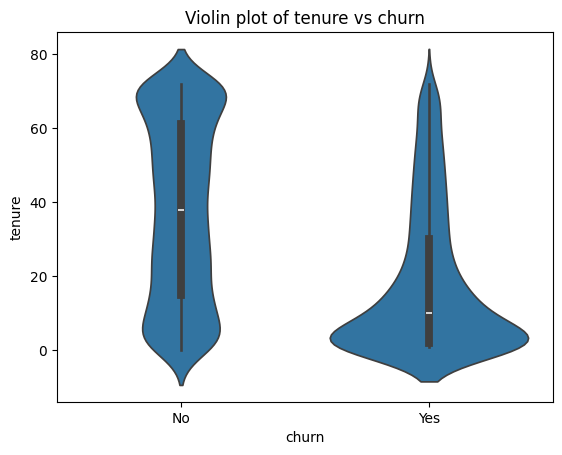

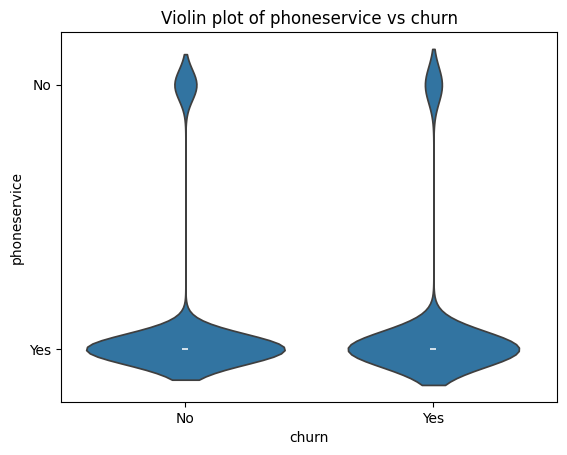

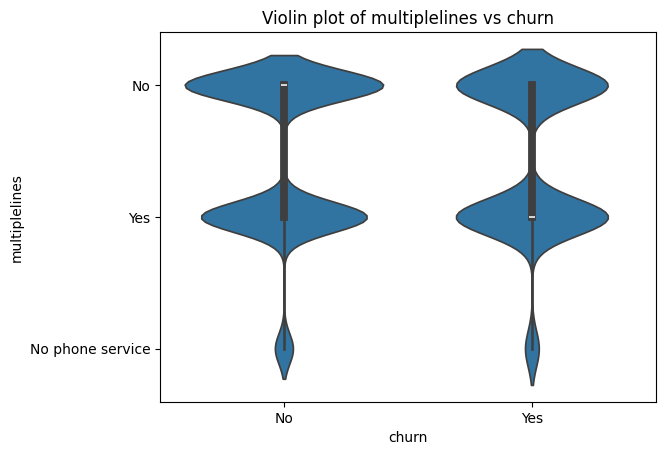

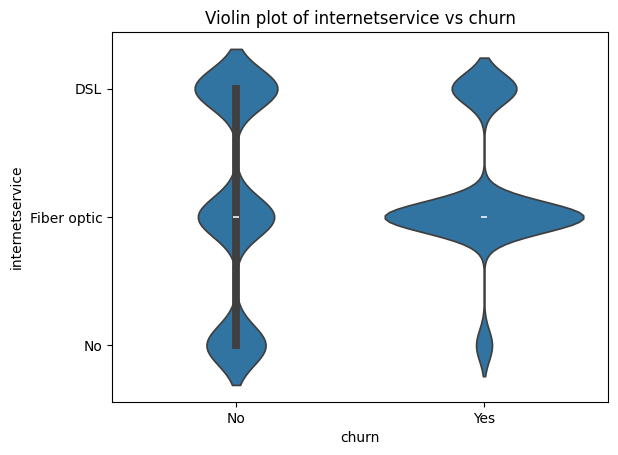

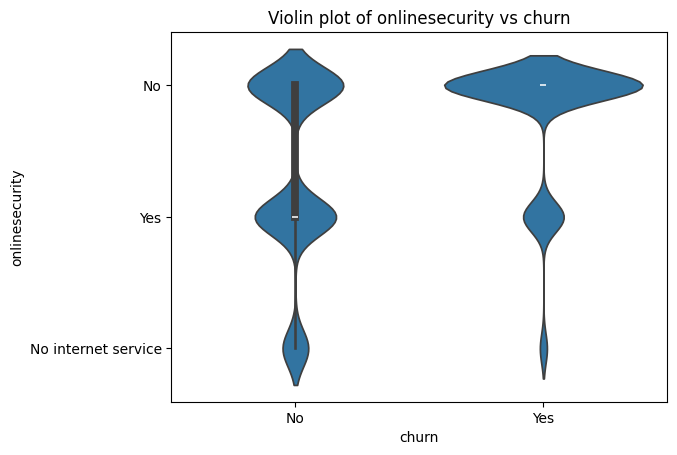

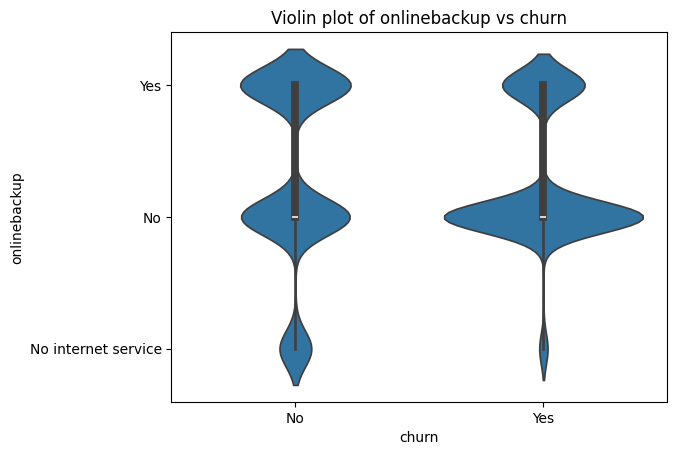

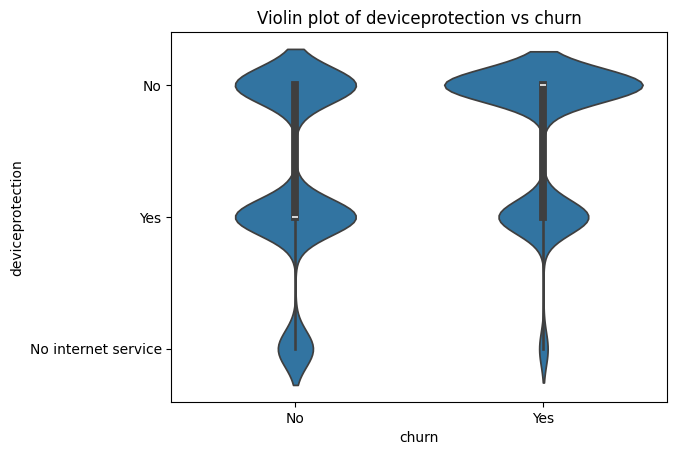

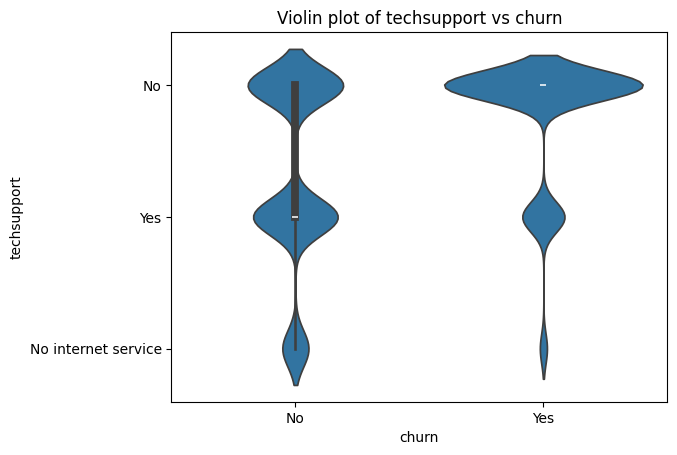

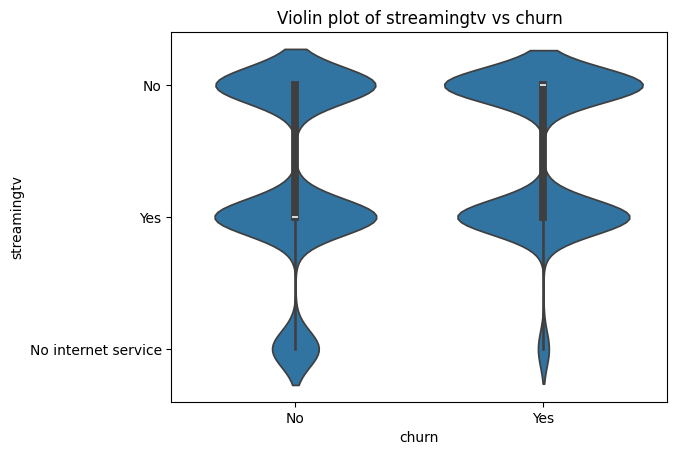

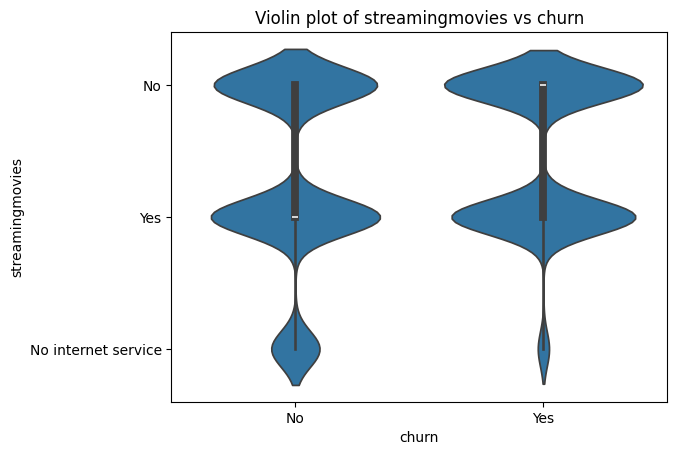

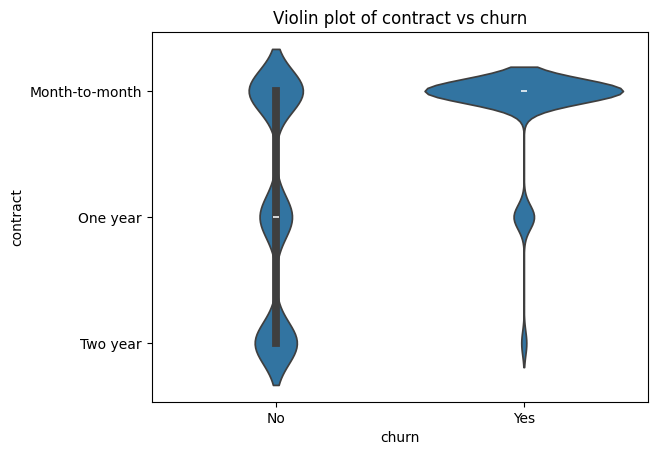

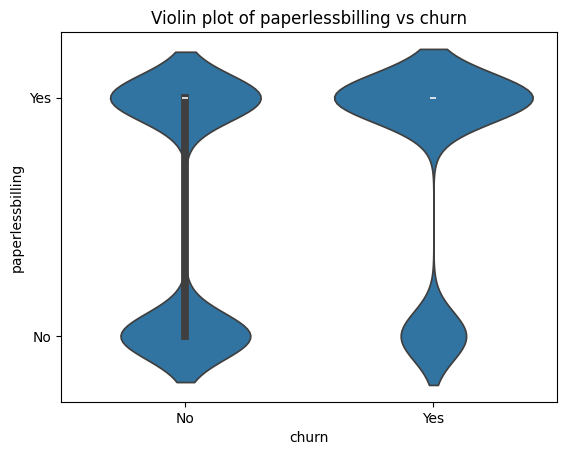

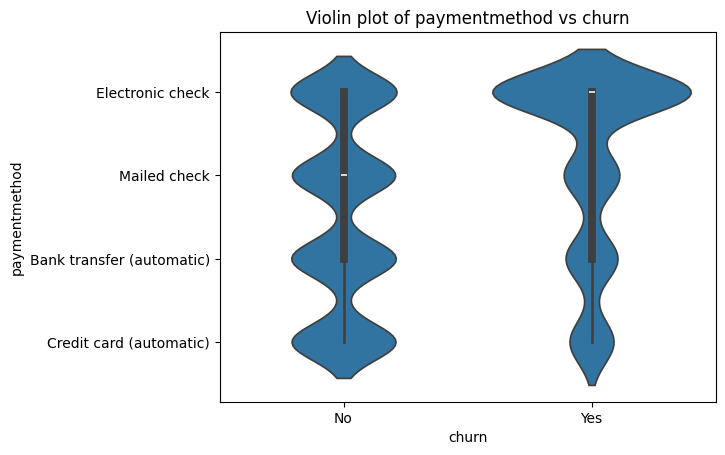

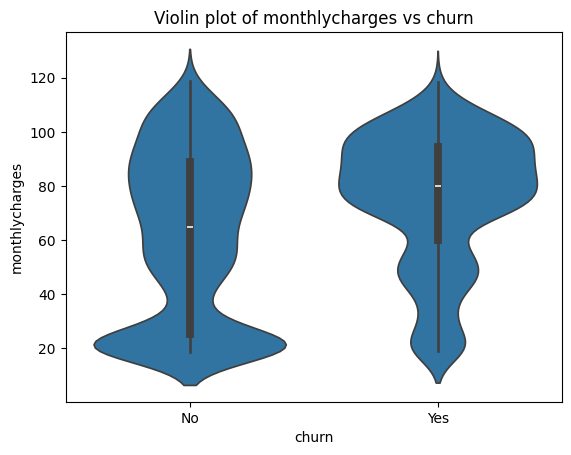

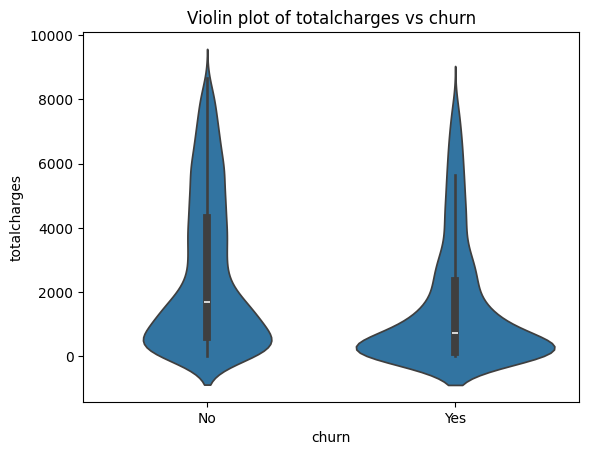

In [32]:
violin_plots(train_data)

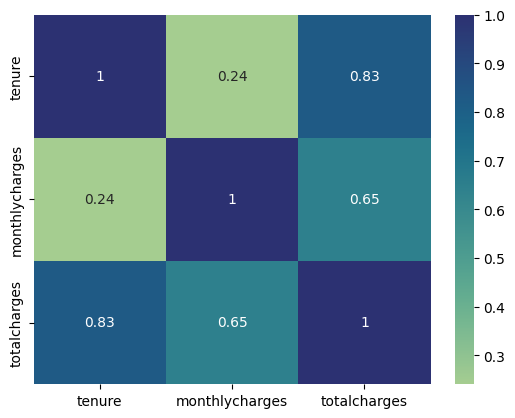

In [33]:
# plot a heatmap for all the numerical columns to show correlation
sns.heatmap(data=train_data.select_dtypes('number').corr(),cmap='crest', annot=True)
plt.show()

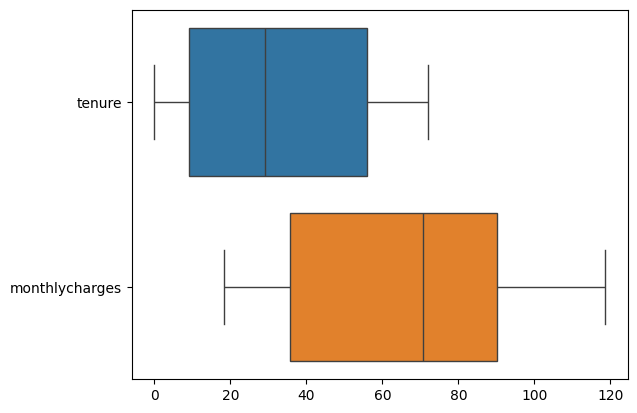

In [ ]:
sns.boxplot(train_data.drop(['totalcharges','seniorcitizen'], axis=1), orient='h')
plt.show()

### Detailed Notes

- **Concatenation of Training Datasets**: We've undertaken the task of merging the two training datasets to create a consolidated dataset. This approach facilitates a comprehensive analysis by providing a unified dataset for examination and modeling.

- **Exclusion of the Third Dataset**: At present, the third dataset doesn't contribute to our immediate objectives. Hence, we've opted to set it aside for now to focus on the datasets at hand.

- **Standardization of Column Names**: In order to enhance data consistency and ease of manipulation, all column names have been converted to lowercase. This standardization ensures uniformity throughout the dataset, simplifying subsequent operations and analyses.

- **Normalization of Responses**: To ensure coherence and clarity in our data, we've implemented a standardization process for response values. Accordingly, both 'True' and 'Yes' now signify affirmative responses, while 'False' and 'No' denote negative responses. This adjustment eliminates potential discrepancies and facilitates more accurate interpretation of the data.

- **Exclusion of Customer ID**: Recognizing that the Customer ID variable does not contribute meaningfully to our analytical goals, we've opted to remove it from the dataset. This omission streamlines our dataset and focuses our analysis on pertinent variables.

- **Conversion of 'Total Charges' Data Type**: In order to conduct precise numerical analyses, we've converted the data type of the 'Total Charges' column from object to numeric. This modification enables us to accurately perform mathematical operations and statistical analyses involving this variable.

- **Data Skewness and Scaling**: Given the presence of skewed data within the dataset, we recognize the importance of data scaling to ensure uniformity and accuracy in our analyses. By scaling the data, we mitigate the impact of skewed distributions, thereby facilitating more reliable and meaningful insights.


## **`Data PREPARATION`**